<a href="https://colab.research.google.com/github/Juancarlos56/Repositorio-Simulacion-10/blob/main/Evaluaciones/Segundo-Interciclo/Prueba4_Simpy_Simulacion-Correcion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Distribucion de Probabilidad

In [3]:
import simpy
import random
import matplotlib.pyplot as plt
from numpy import random as nprandom

#Distribucion Binomial
def tipoVehiculo():
    return nprandom.binomial(n=1, p=0.15, size=10)

#Distribucion Binomial
def tipoVehiculoParaRevision():
    return nprandom.binomial(n=1, p=0.15, size=1)

#Distribucion Binomial
def pasoRevisionVehiculo():
    return nprandom.binomial(n=1, p=0.6, size=1)

#Distribucion normal
def entrada_a_revision():
    return abs(random.normalvariate(20, 10))

In [ ]:
nprandom.binomial(n=1, p=0.15, size=10)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

### Simulación Eventos Discretos

In [35]:
import simpy
import random
import matplotlib.pyplot as plt
import math

# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57 
# Total de maquinas de lavado con que cuenta el negocio
NUM_Carriles = 3
# Tiempo que tarda en en llegada del vehiculo(minutos)
TIEMPO_Revision = 9 
# Intervalo de tiempo en que llegan vehiculos (minutos)
INTERVALO_LLEGADA = 3
# Tiempo de simulación
TIEMPO_SIMULACION = 1440*30
#Tipos de Vehiculos
TIPOS_VEHICULOS = ['BUS','BUSETAS', 'CAMIONES']

# Creamos un diccionario para almacenar las horas en que se lavan los vehiculos
# Esto permite graficar o generar los resultados
tiempo={}
tiempo={}
listaAutosAprobados = {}
listaAutosReparacion = {}
listaAutosAprobadosGraficas = {}
listaAutosReparacionGraficas = {}
listadoAutosPorCarril1_Tonelaje = [] 
listadoAutosPorCarril2_normal = [] 
listadoAutosPorCarril3_normal = [] 

class EMOV(object):
    
    def __init__(self, environment, numeroCarrile):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las carriles
        self.carrilesLivianos = simpy.Resource(environment, numeroCarrile)
        self.carrilesPesados = simpy.Resource(environment, numeroCarrile-2)
    
    def salidaEMOV(self):
      yield self.env.timeout(random.randint(5,10))

    def pegar_sello_revision(self):
      yield self.env.timeout(random.randint(1,3))

    def realizarReparacion(self):
        yield self.env.timeout(1440*2)

    def revision_vehiculo(self, nombre, tipoVehiculo):
        yield self.env.timeout(entrada_a_revision())

    def llegadaVehiculo_estacionamiento(self, nombre, tipoVehiculo):
        yield self.env.timeout(random.randint(3,5))

    def llegdaVehiculo_sacaTurno(self, nombre, tipoVehiculo):
        yield self.env.timeout(random.randint(1,3))

    def llegdaVehiculo_pagoMatricula(self, nombre, tipoVehiculo):
        yield self.env.timeout(random.randint(5,10))

def pasoRevision(env, nombre, tipoVehiculo):
    global listaAutosAprobados
    global listaAutosReparacion
    global listaAutosAprobadosGraficas
    global listaAutosReparacionGraficas
    global listadoAutosPorCarril1_Tonelaje
    global listadoAutosPorCarril2_normal
    global listadoAutosPorCarril3_normal

    revision = pasoRevisionVehiculo()
    ## 0 pasa la revision y 1 no pasa
    if(revision == 0):  
      listaAutosAprobados[nombre]=[tipoVehiculo, math.trunc(round(env.now)/1440)]
      listaAutosAprobadosGraficas[nombre]=[tipoVehiculo, math.trunc(round(env.now)/1440)]

    elif(revision == 1): 
      listaAutosReparacion[nombre]=[tipoVehiculo, math.trunc(round(env.now)/1440)+2]
      listaAutosReparacionGraficas[nombre]=[tipoVehiculo, math.trunc(round(env.now)/1440)+2]

def llegada_vehiculo(env, nombre, emov, tipoVehiculo):
    # Especificamos que vamos a usar un recurso (Resource) que representa el vehiculo
    

    if tipoVehiculo is not 'Normal':
      with emov.carrilesPesados.request() as carrilesPesados:
          yield carrilesPesados
          #print("LLegada del vehiculo %s a las %.2f."%(nombre, env.now))
          yield env.process(emov.llegadaVehiculo_estacionamiento(nombre,tipoVehiculo))
          yield env.process(emov.llegdaVehiculo_sacaTurno(nombre,tipoVehiculo))
          yield env.process(emov.llegdaVehiculo_pagoMatricula(nombre,tipoVehiculo))
          #print("Termina proceso de llegada del vehiculo %s a la hora: %.2f." %(nombre, env.now))
          
          yield env.process(emov.revision_vehiculo(nombre, tipoVehiculo))
          pasoRevision(env, nombre, tipoVehiculo)
          yield env.process(emov.pegar_sello_revision())
          yield env.process(emov.salidaEMOV())
          listadoAutosPorCarril1_Tonelaje.append(1)
          k=math.trunc(round(env.now)/1440) # Permite obtener el tiempo actual de la simulación para generar la clave del diccionario

    else:
       with emov.carrilesLivianos.request() as carrilesLivianos:
          yield carrilesLivianos
          #print("LLegada del vehiculo %s a las %.2f."%(nombre, env.now))
          yield env.process(emov.llegadaVehiculo_estacionamiento(nombre,tipoVehiculo))
          yield env.process(emov.llegdaVehiculo_sacaTurno(nombre,tipoVehiculo))
          yield env.process(emov.llegdaVehiculo_pagoMatricula(nombre,tipoVehiculo))
          #print("Termina proceso de llegada del vehiculo %s a la hora: %.2f." %(nombre, env.now))
          yield env.process(emov.revision_vehiculo(nombre, tipoVehiculo))
          pasoRevision(env, nombre, tipoVehiculo)
          yield env.process(emov.pegar_sello_revision())
          yield env.process(emov.salidaEMOV())
          listadoAutosPorCarril2_normal.append(1)
          k=math.trunc(round(env.now)/1440) # Permite obtener el tiempo actual de la simulación para generar la clave del diccionario

    if k in tiempo:
        tiempo[k]=tiempo[k]+1 # Aumento el numero de autos en el tiempo de salida
    else:
        tiempo[k]=1 # Por defecto empezamos con el primer vehiculo

def ejecutar_simulacion(env, numeroCarriles, tiempoMinimoRevesion, intervaloLlegada):
    global listaAutosReparacion

    emov=EMOV(env, numeroCarriles)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(5):
        tipoVehiculo = tipoVehiculoParaRevision()
        if(tipoVehiculo == 1):
          vehiculo = TIPOS_VEHICULOS[random.randint(0,2)]
        elif(tipoVehiculo == 0):
          vehiculo = 'Normal' 

        env.process(llegada_vehiculo(env, 'Vehiculo-%d'%(i+1),emov, vehiculo))
    
    # Ejecutamos la simulacion
    cont = 0
    while True:
      yield env.timeout(3)
      dia = math.trunc(round(env.now)/1440)
      
      ##Verificar que sea para cada dos dias 
      for key in listaAutosReparacion.copy():
        if(listaAutosReparacion[key][1] == dia):
          env.process(llegada_vehiculo(env,key,emov, listaAutosReparacion[key]))
          del listaAutosReparacion[key]
          yield env.timeout(3)
          break;
      i+=1
      # Mientras se REVISAN los vehiculos generamos mas vehiculos
      tipoVehiculo = tipoVehiculoParaRevision()
      if(tipoVehiculo == 1):
        vehiculo = TIPOS_VEHICULOS[random.randint(0,2)]
      elif(tipoVehiculo == 0):
        vehiculo = 'Normal' 
      env.process(llegada_vehiculo(env,'Vehiculo-%d'%(i+1),emov, vehiculo))
    

In [36]:

print('EMOV - Juan Barrera')
# Inicializamos la semilla aleatoria
random.seed(77)

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_Carriles, TIEMPO_Revision, INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

tiempoCon3Maquinas = tiempo

EMOV - Juan Barrera


### Generar un modelo de simulación por 30 dias y generar las siguientes graficas de resultados:


#### Numero de vehiculos atendidos por dia, y por carril

In [16]:
print("lista por carril 1: ", len(listadoAutosPorCarril1_Tonelaje))

lista por carril 1:  1006


In [17]:
print("lista por carril 2-3: ", len(listadoAutosPorCarril2_normal))

lista por carril 2-3:  3015


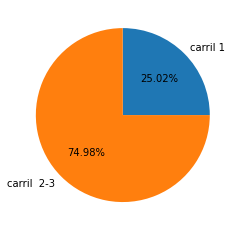

In [26]:

nombres = ["carril 1","carril  2-3"]
plt.pie([1006, 3015], labels=nombres,autopct='%1.2f%%')
plt.show()


#### Porcentaje total de vehiculos aprobados y no aprobados en cuenca aire por dia

In [18]:
print("Autos Aprobados: ", len(listaAutosAprobadosGraficas))

Autos Aprobados:  1587


In [19]:
print("Autos Reparacion: ", len(listaAutosReparacionGraficas))

Autos Reparacion:  2130


In [12]:
print("total: ",str(len(listaAutosAprobadosGraficas)+len(listaAutosReparacionGraficas)))

total:  3716


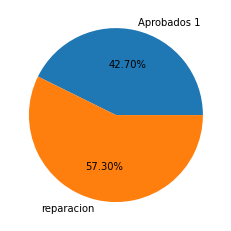

In [27]:
nombres = ["Aprobados 1","reparacion"]
plt.pie([1587, 2130], labels=nombres,autopct='%1.2f%%')
plt.show()

#### Tiempos del proceso de matriculación, por dia.

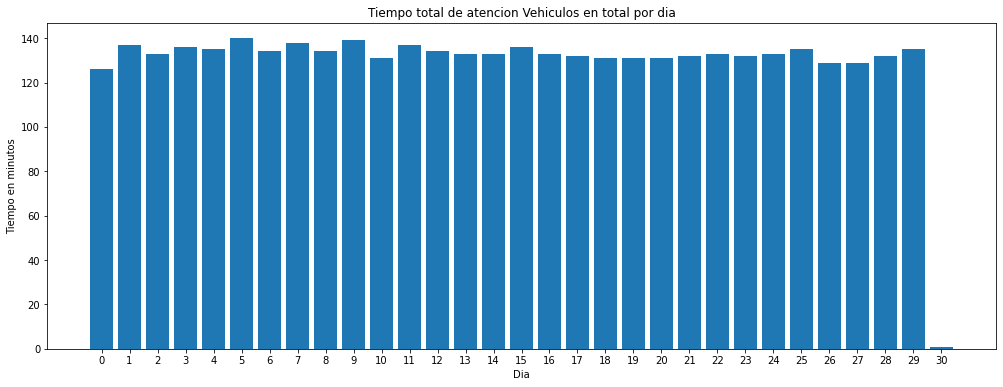

In [34]:

etiqueta = list(tiempo.keys())
valores = list(tiempo.values())
plt.figure(figsize=(17,6), )
plt.bar(range(len(tiempo)), valores, align="center", tick_label=etiqueta)
plt.title("Tiempo total de atencion Vehiculos en total por dia")
plt.xlabel("Dia")
plt.ylabel("Tiempo en minutos")
plt.show()